# Stakeholder

A real estate company is looking to invest in non-luxury, single-family homes in King County, WA. They think this market will grow over time. They want information on several factors that influence the price of such homes.

In this project I define a non-luxury, single-family home as a house less than $3 million dollars, with over 1500 square feet of living space, and 3 or more bedrooms.

In [180]:
import pandas as pd
pd.set_option('display.max_columns', 500)

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import shapiro
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
import plotly.express as px
import geopy.distance

In [181]:
houses = pd.read_csv("data/kc_house_data.csv")

# Non-Linear Relationships with Price

First, we will find which numeric variables have a roughly linear relationship with price. Any that don't cannot be used in our model.

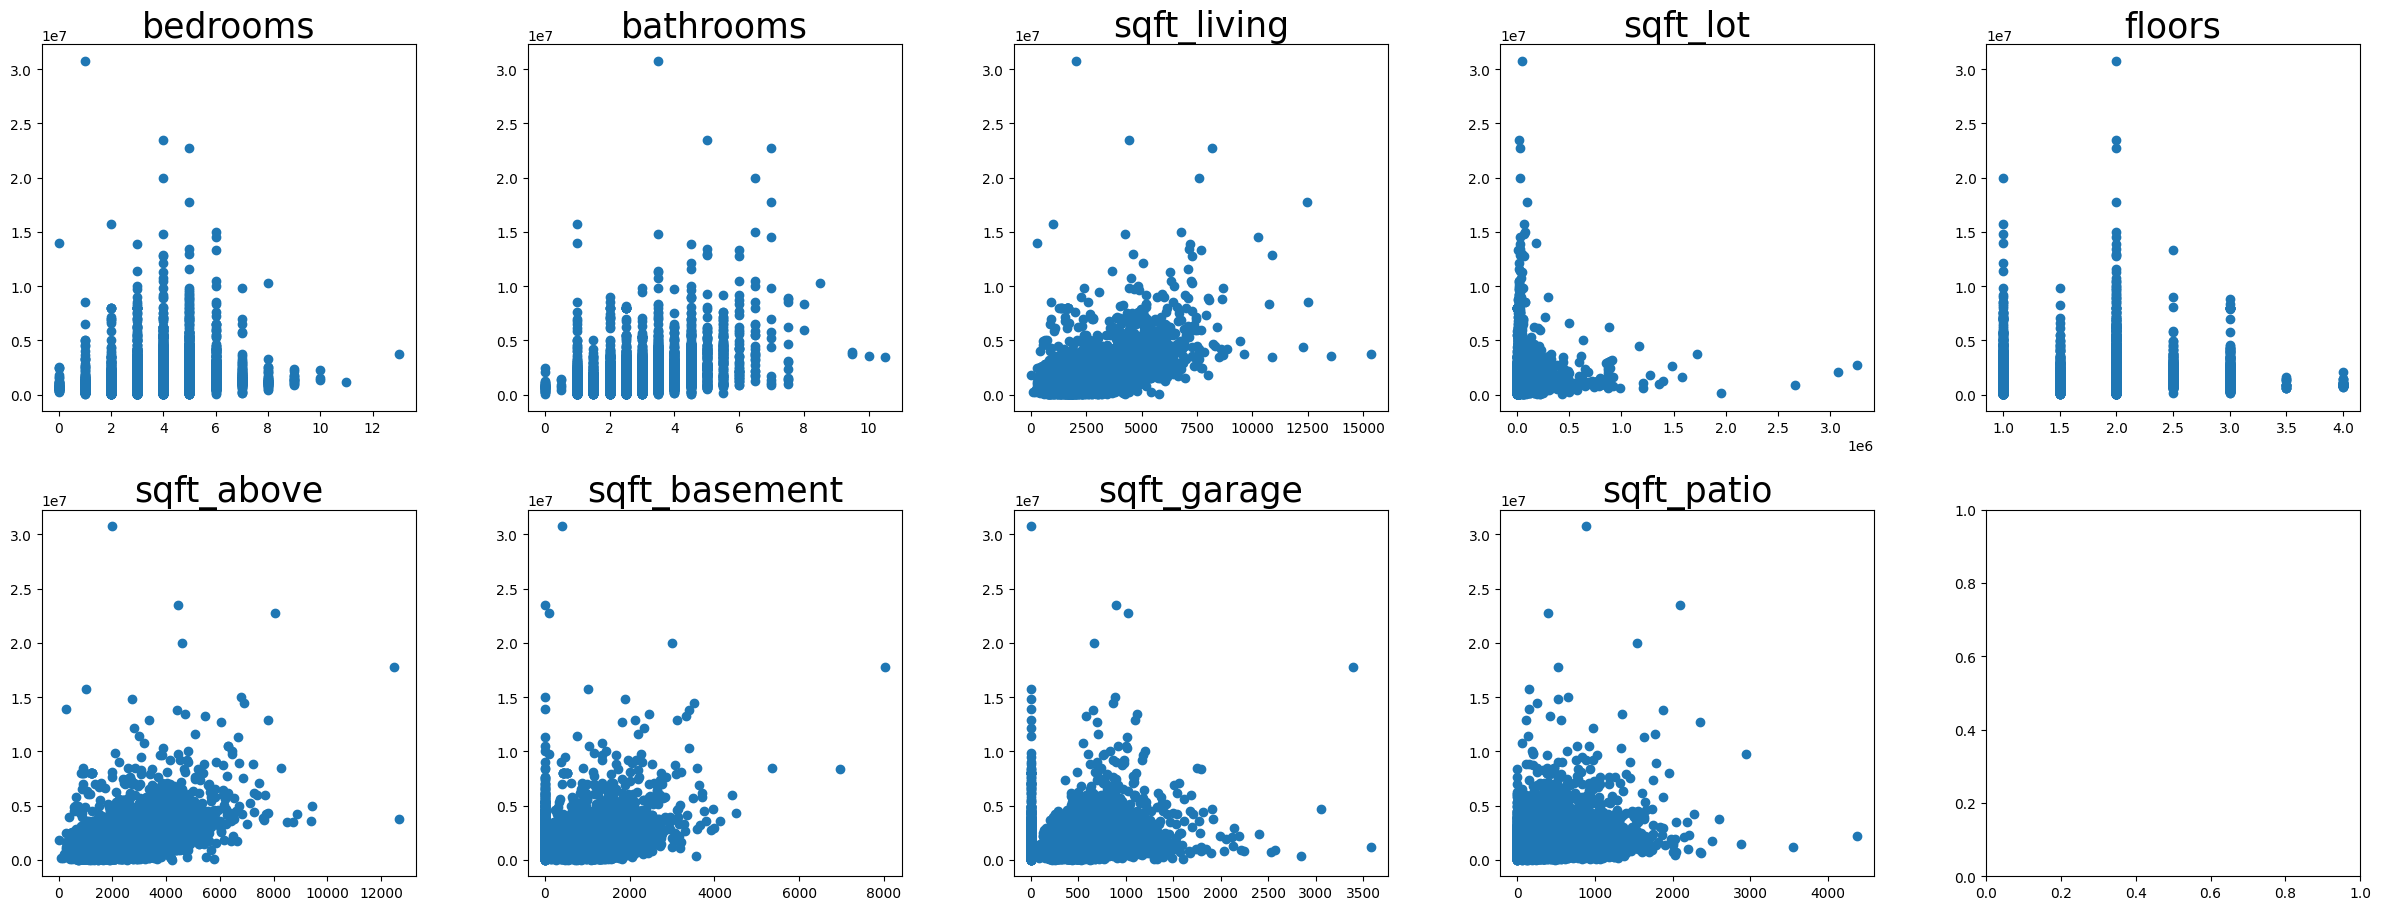

In [182]:
fig, ax = plt.subplots(2,5, figsize=(25,10))
fig.tight_layout(pad=5.0)
cols = ['bedrooms', 'bathrooms', 'sqft_living', 
        'sqft_lot', 'floors', 'sqft_above', 
        'sqft_basement', 'sqft_garage', 'sqft_patio']

for i in range(10):

    row = i//5
    col=i%5


    try:
        ax[row][col].scatter(houses[cols[i]], houses.price)
        ax[row][col].set_title(cols[i], size=25)
    except:
        break

It looks like the bedrooms variable, sqft_lot variable, floors, sqft_garage, sqft_basement, and sqft_patio variables do not seen to have a linear relationship with price. We will not be using them in our model.

# Outliers

Any outliers can be seen via histograms of the numeric variables. Outliers in the categorial variables can be categories that have less than 10 values.

In [183]:
houses = houses.drop(houses.query('bedrooms < 3 or \
                      sqft_living < 1500 or\
                      price > 3_000_000').index)

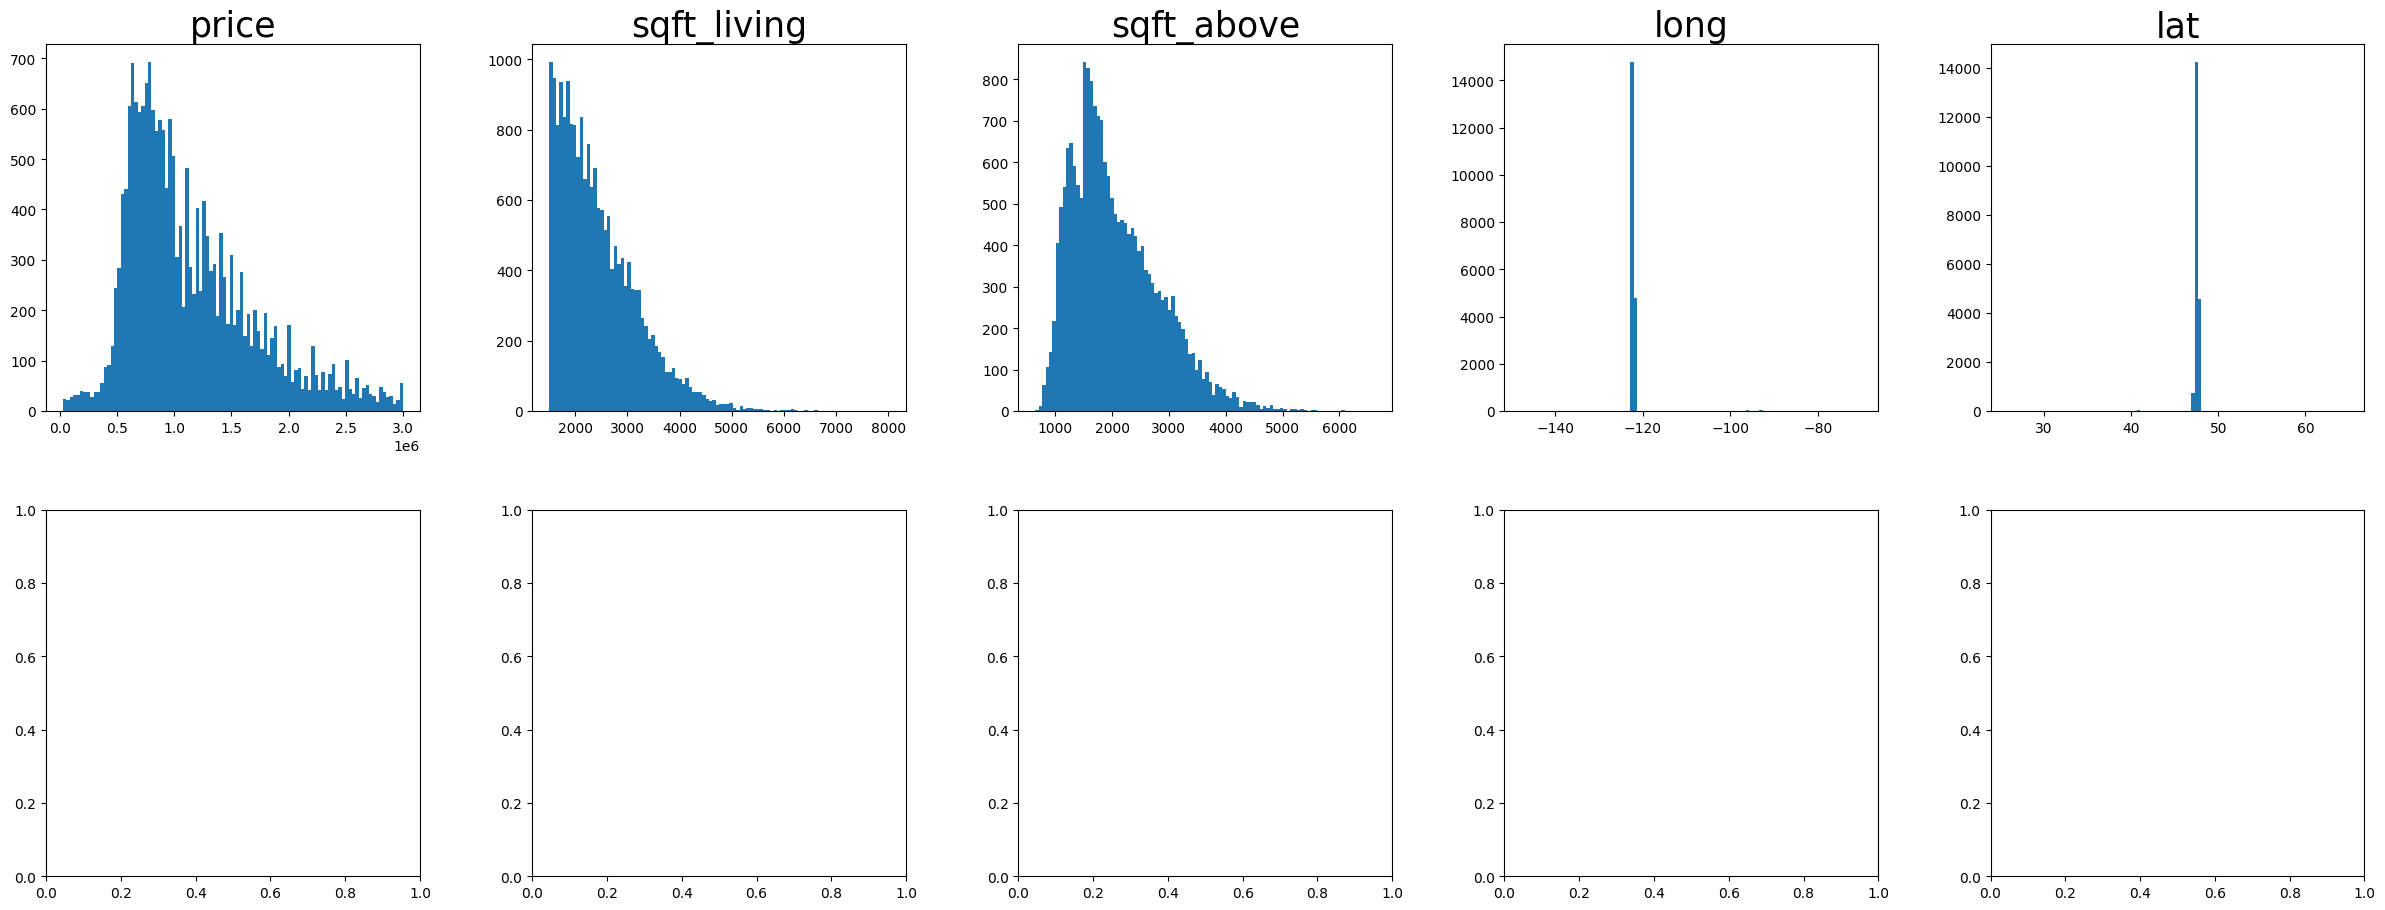

In [184]:
fig, ax = plt.subplots(2,5, figsize=(25,10))
fig.tight_layout(pad=5.0)
cols = ['price', 'sqft_living', 'sqft_above', 'long', 'lat']

for i in range(10):

    row = i//5
    col=i%5


    try:
        ax[row][col].hist(houses[cols[i]], bins=100)
        ax[row][col].set_title(cols[i], size=25)
    except:
        break

In [185]:
houses = houses.query('long > -125 & long < -120 & lat > 47 & lat < 48')

In [186]:
cols = ['bedrooms', 'bathrooms', 'floors', 'condition', 'view', 'grade', 'heat_source', 'sewer_system']

for col in cols:
    value_counts = dict(houses[col].value_counts())
    for key in value_counts.keys():
        if value_counts[key] <= 10:
            houses = houses[~(houses[col] == key)]
        
for col in cols:
    print(houses[col].value_counts())

4    8725
3    7795
5    2457
6     422
7      67
8      34
9      12
Name: bedrooms, dtype: int64
2.5    7289
2.0    4155
3.0    3864
3.5    1903
1.5     681
1.0     568
4.0     564
4.5     337
5.0      88
5.5      39
6.0      24
Name: bathrooms, dtype: int64
2.0    9787
1.0    7572
1.5    1604
3.0     376
2.5     160
4.0      13
Name: floors, dtype: int64
Average      11890
Good          5311
Very Good     2200
Fair            94
Poor            17
Name: condition, dtype: int64
NONE         17009
AVERAGE       1410
GOOD           653
EXCELLENT      284
FAIR           156
Name: view, dtype: int64
8 Good           7443
7 Average        7010
9 Better         3198
10 Very Good     1060
6 Low Average     533
11 Excellent      206
12 Luxury          33
5 Fair             29
Name: grade, dtype: int64
Gas                  14972
Electricity           2970
Oil                   1458
Gas/Solar               72
Electricity/Solar       37
Name: heat_source, dtype: int64
PUBLIC     16549
PRIVATE  

Since we are looking at "non-luxury" homes, it only makes sense to drop homes with a grade of "luxury."

In [187]:
houses = houses[~(houses.grade == '12 Luxury')]

# Initial model

We will attempt to create a model based on the features we already have.

In [188]:
cols = ['bathrooms', 'sqft_living', 'waterfront', 'greenbelt', 'nuisance', 'view', 'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above']

col_dict = {"variables": cols, "rsquared_adj": []}

for col in cols:
    model = sm.OLS.from_formula(f"price ~ {col}", data=houses)
    results = model.fit()
    col_dict["rsquared_adj"].append(results.rsquared_adj)
    
pd.DataFrame(col_dict).sort_values(by="rsquared_adj", ascending=False)

,variables,rsquared_adj
7,grade,0.343780
1,sqft_living,0.310335
10,sqft_above,0.196935
0,bathrooms,0.151167
5,view,0.052066
8,heat_source,0.017755
3,greenbelt,0.009275
2,waterfront,0.005159
6,condition,0.003233
9,sewer_system,0.000273


It looks like grade, sqft_living, sqft_above, and bathrooms are all good variables to put into our model. It only remains to be seen whether or not any of these variables are highly correlated with each other. Since we don't want collinearity in our model, we have to determine this.

In [189]:
houses[['grade', 'sqft_living', 'sqft_above', 'bathrooms']].corr(numeric_only = True)

,sqft_living,sqft_above,bathrooms
sqft_living,1.000000,0.795563,0.632813
sqft_above,0.795563,1.000000,0.498277
bathrooms,0.632813,0.498277,1.000000


It looks like the sqft_above column is highly correlated with sqft_living. Of the two, I will drop sqft_above from our dataset, because it is less powerful in the model than sqft_living.

In [190]:
houses.drop(['sqft_above'], axis=1, inplace=True)

In [191]:
model = sm.OLS.from_formula(f"price ~ sqft_living + C(grade) + bathrooms", data=houses)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     1619.
Date:                Tue, 20 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:37:14   Log-Likelihood:            -2.8041e+05
No. Observations:               19479   AIC:                         5.608e+05
Df Residuals:                   19470   BIC:                         5.609e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

This is not a good model; all the features are statistically significant, but the adjusted R-squared value is only 0.4, which is below optimal.

# Second model

We will create some engineered features for this model to try and improve model performance. First, we will have:

- Average price of nearby houses (using zip-code)
- Distance from [x]

In [192]:
houses['zipcode'] = houses.address.map(lambda x: x.split(',')[-2].split(' ')[-1])

In [193]:
houses = houses[houses.groupby('zipcode')['zipcode'].transform('count') > 50]

In [194]:
zipcode_prices = []
for i in range(len(houses)):
    zipcode = houses.iloc[i].zipcode
    identifier = houses.iloc[i].id
    subset = houses[(houses.zipcode == zipcode) & (houses.id != identifier)]
    zipcode_price = subset.price.mean()
    zipcode_prices.append(zipcode_price)
    
houses['zipcode_price'] = zipcode_prices

/var/folders/s6/jlb2zd1s5gq39tnl2x_y5z_r0000gn/T/ipykernel_95189/3839997715.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houses['zipcode_price'] = zipcode_prices


In [195]:
lat_square = (47.213232398310396 - 47.1992389962046)
long_square = (-121.38307527465054 - -121.3939406543853)

# For every house, we calculate how many houses are in a square-shaped area around them.
# Also, we calculate the average price of houses in that area.
# From this data we get average price of houses in the vicinity as well as the density of that area.
# The house whose price we are trying to predict is eliminated from the mean vicinity price.
# Only houses sold before the target house are included in the mean price.

lengths = []
vicinity_means = []

for i in range(len(houses)):
    lat, long = houses.iloc[i].lat, houses.iloc[i].long
    area = houses[(houses.lat < lat+lat_square) & 
                  (houses.lat > lat-lat_square) & 
                  (houses.long < long+long_square) & 
                  (houses.long > long-long_square) & 
                  (houses.long != long) & 
                  (houses.lat != lat)]

    lengths.append(len(area))
    vicinity_means.append(area.price.mean())

In [196]:
# Some of these houses have no other houses in their area.
# These records are dropped, and there are only a couple.

houses['vicinity_num'] = lengths
houses['vicinity_price'] = vicinity_means
houses = houses[houses.vicinity_num >= 5]

/var/folders/s6/jlb2zd1s5gq39tnl2x_y5z_r0000gn/T/ipykernel_95189/1744961439.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houses['vicinity_num'] = lengths
/var/folders/s6/jlb2zd1s5gq39tnl2x_y5z_r0000gn/T/ipykernel_95189/1744961439.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houses['vicinity_price'] = vicinity_means


In [197]:
# Creating a "coordinate" variable in a lat/long tuple format.
houses['coordinate'] = list(zip(houses['lat'], houses['long']))

highest_price = (47.62637851929106, -122.22555549295355)
houses['distance_from_bellevue'] = houses['coordinate'].map(lambda x: geopy.distance.geodesic(x, highest_price).km)

In [198]:
model = sm.OLS.from_formula(f"price ~ sqft_living + C(grade) + bathrooms + zipcode_price + distance_from_bellevue", data=houses)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     4390.
Date:                Tue, 20 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:37:58   Log-Likelihood:            -2.6933e+05
No. Observations:               19163   AIC:                         5.387e+05
Df Residuals:                   19152   BIC:                         5.388e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

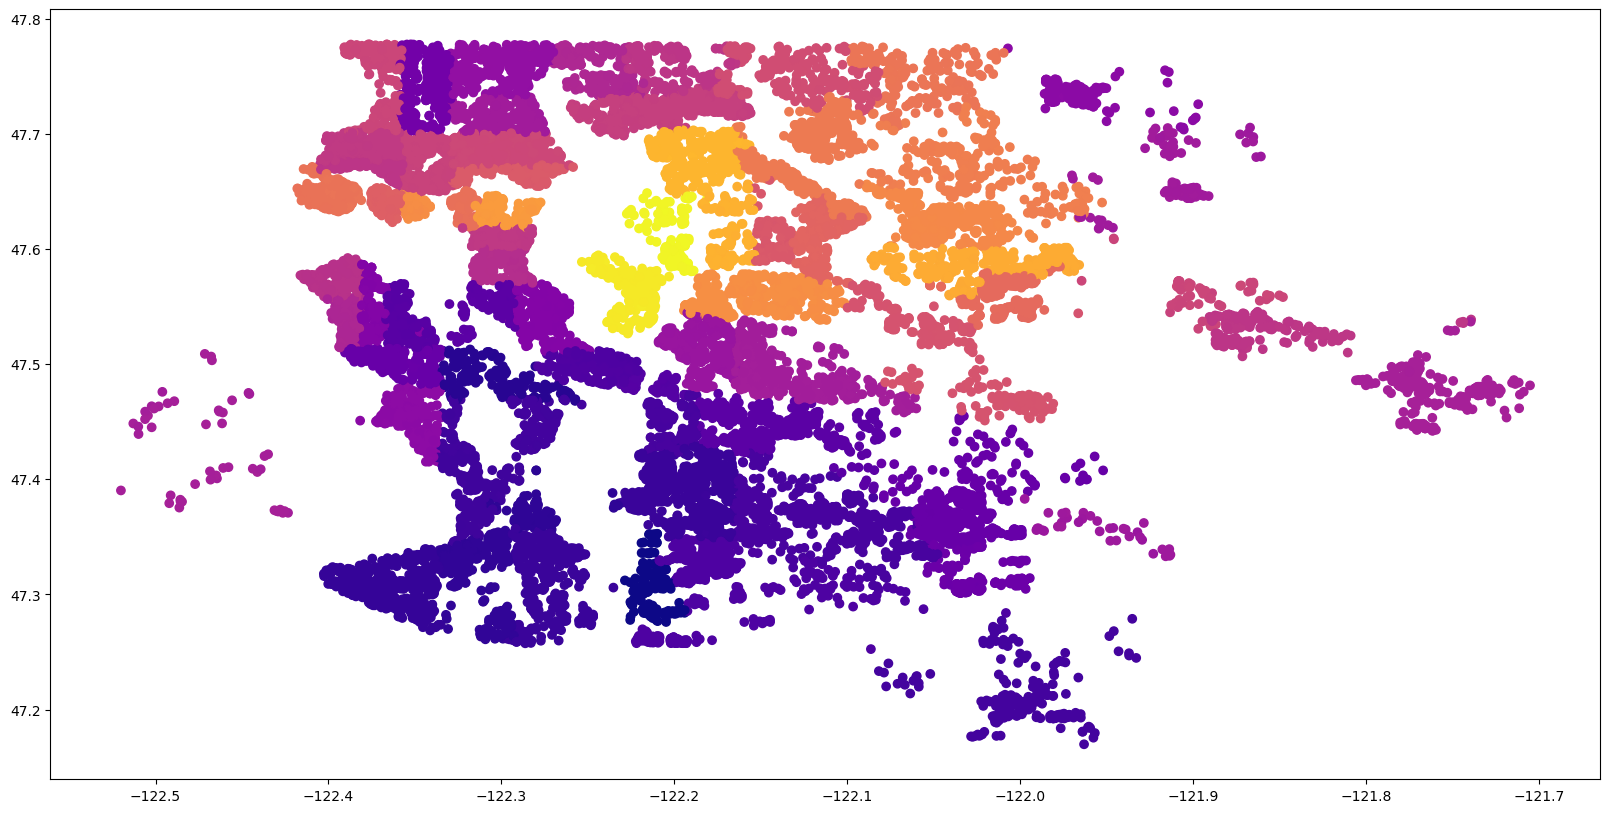

In [199]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(houses.long, houses.lat, c=houses.zipcode_price, cmap="plasma");

MAE: 217300.51428285328
RMSE: 94499188953.36829


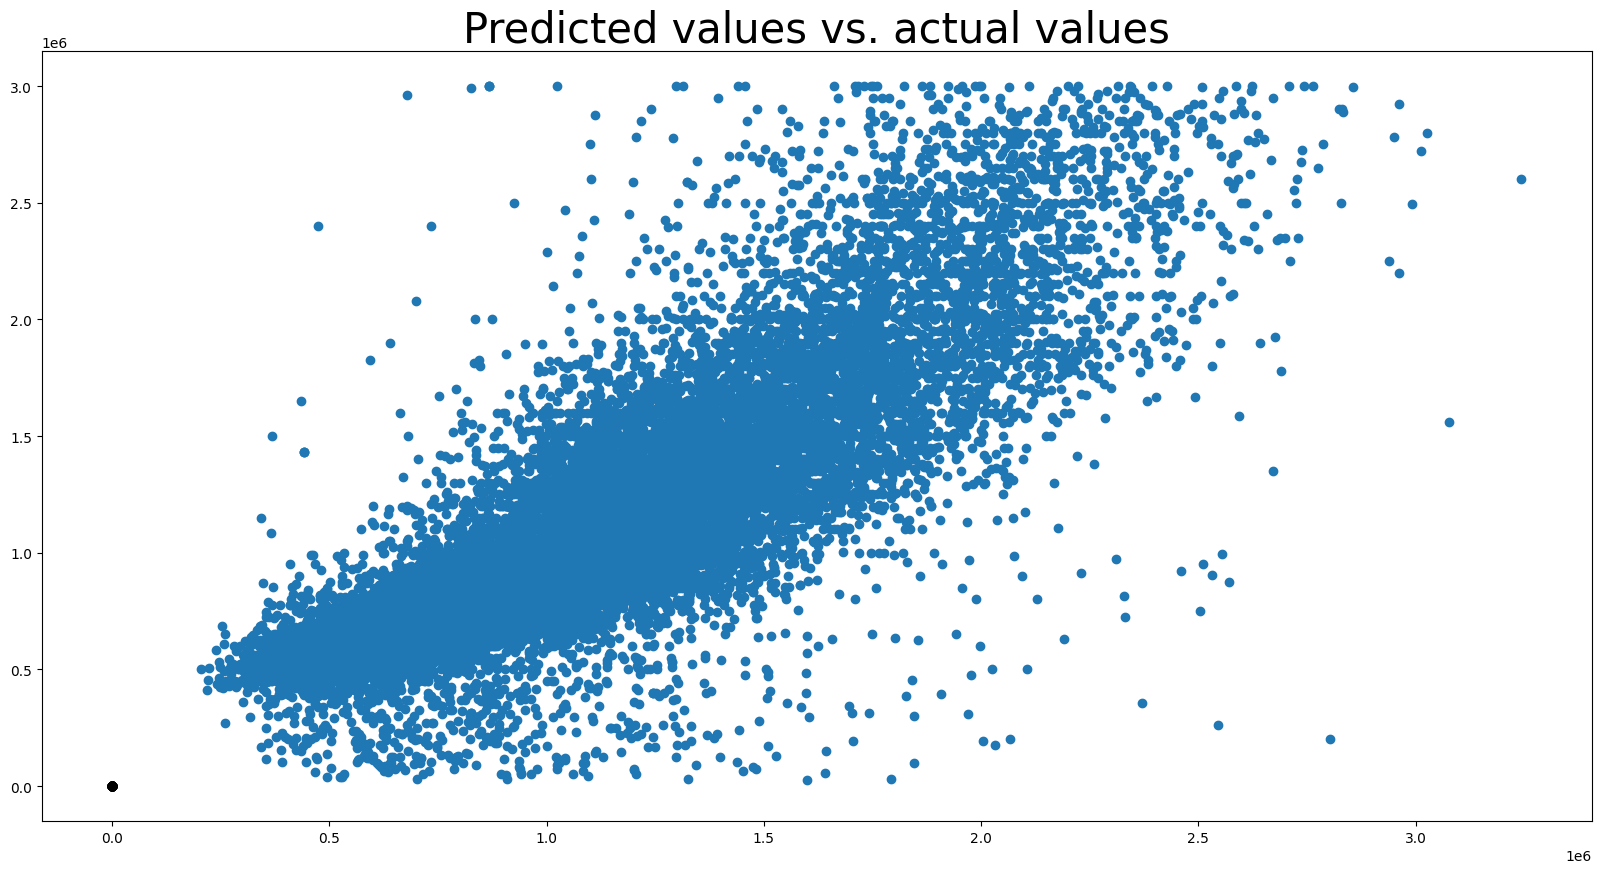

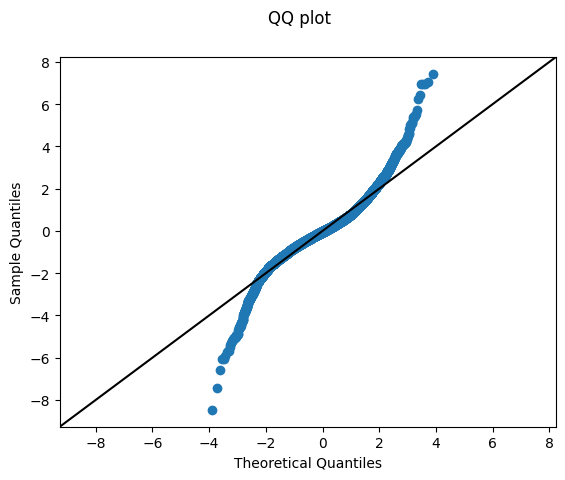

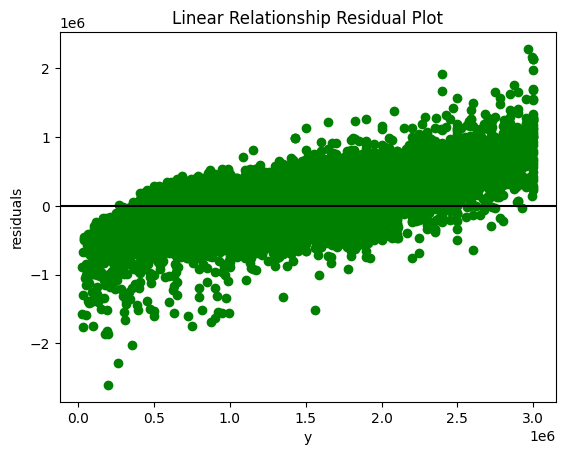

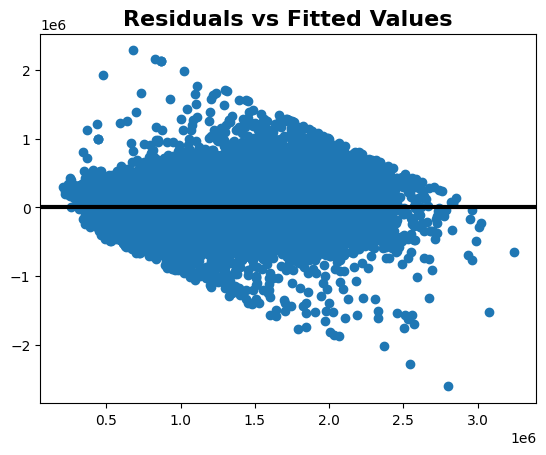

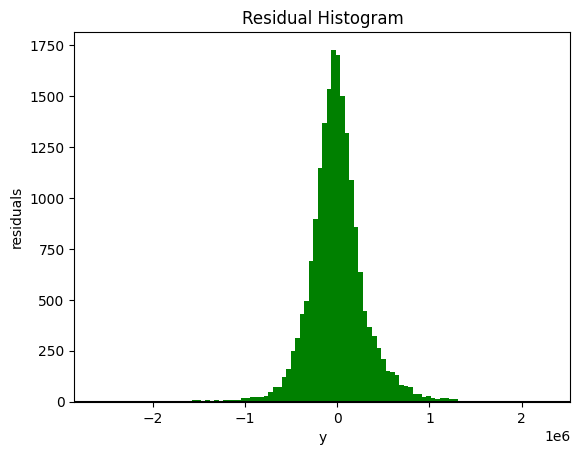

In [200]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(results.predict(houses), houses.price)
ax.scatter(np.linspace(12,16,100), np.linspace(12,16,100), color="black")
ax.set_title("Predicted values vs. actual values", fontsize=30)
# ax.set_ylim(bottom=11, top=17)
# ax.set_xlim(left=12, right=16)

# fig = plt.figure(figsize=(15,10))
# sm.graphics.plot_partregress_grid(results, fig=fig)
# print("\n")

fig, ax = plt.subplots()
sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True, ax=ax)
line = ax.lines[1]
line.set_color("black")
fig.suptitle("QQ plot")

fig, ax = plt.subplots()
ax.scatter(model.endog, results.resid, color="green")
ax.axhline(y=0, color="black")
ax.set_xlabel("y")
ax.set_ylabel("residuals")
ax.set_title("Linear Relationship Residual Plot")

fitted_values = results.predict(houses)
residuals = houses.price - fitted_values
fig, ax = plt.subplots()
ax.scatter(fitted_values, residuals)
ax.axhline(y=0, color='black', linestyle='-', linewidth=3)
ax.set_title('Residuals vs Fitted Values', fontsize=16, weight='bold')

fig, ax = plt.subplots()
ax.hist(results.resid, color="green", bins=100)
ax.axhline(y=0, color="black")
ax.set_xlabel("y")
ax.set_ylabel("residuals")
ax.set_title("Residual Histogram")

mae = mean_absolute_error(houses.price, results.predict(houses))
rmse = mean_squared_error(houses.price, results.predict(houses))
print (f"MAE: {mae}\nRMSE: {rmse}")

# Third Model

Let's try log-transforming some of the numeric variables and see if this improves model performance.

In [201]:
to_log = ['price', 'sqft_living', 'zipcode_price', 'vicinity_price']

for var in to_log:
    houses[var] = np.log(houses[var])

In [204]:
model = sm.OLS.from_formula(f"price ~ sqft_living + vicinity_price + distance_from_bellevue", data=houses)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                 1.046e+04
Date:                Tue, 20 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:42:53   Log-Likelihood:                -4809.4
No. Observations:               19163   AIC:                             9627.
Df Residuals:                   19159   BIC:                             9658.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2

MAE: 0.19253939586356997
RMSE: 0.09672085504884284


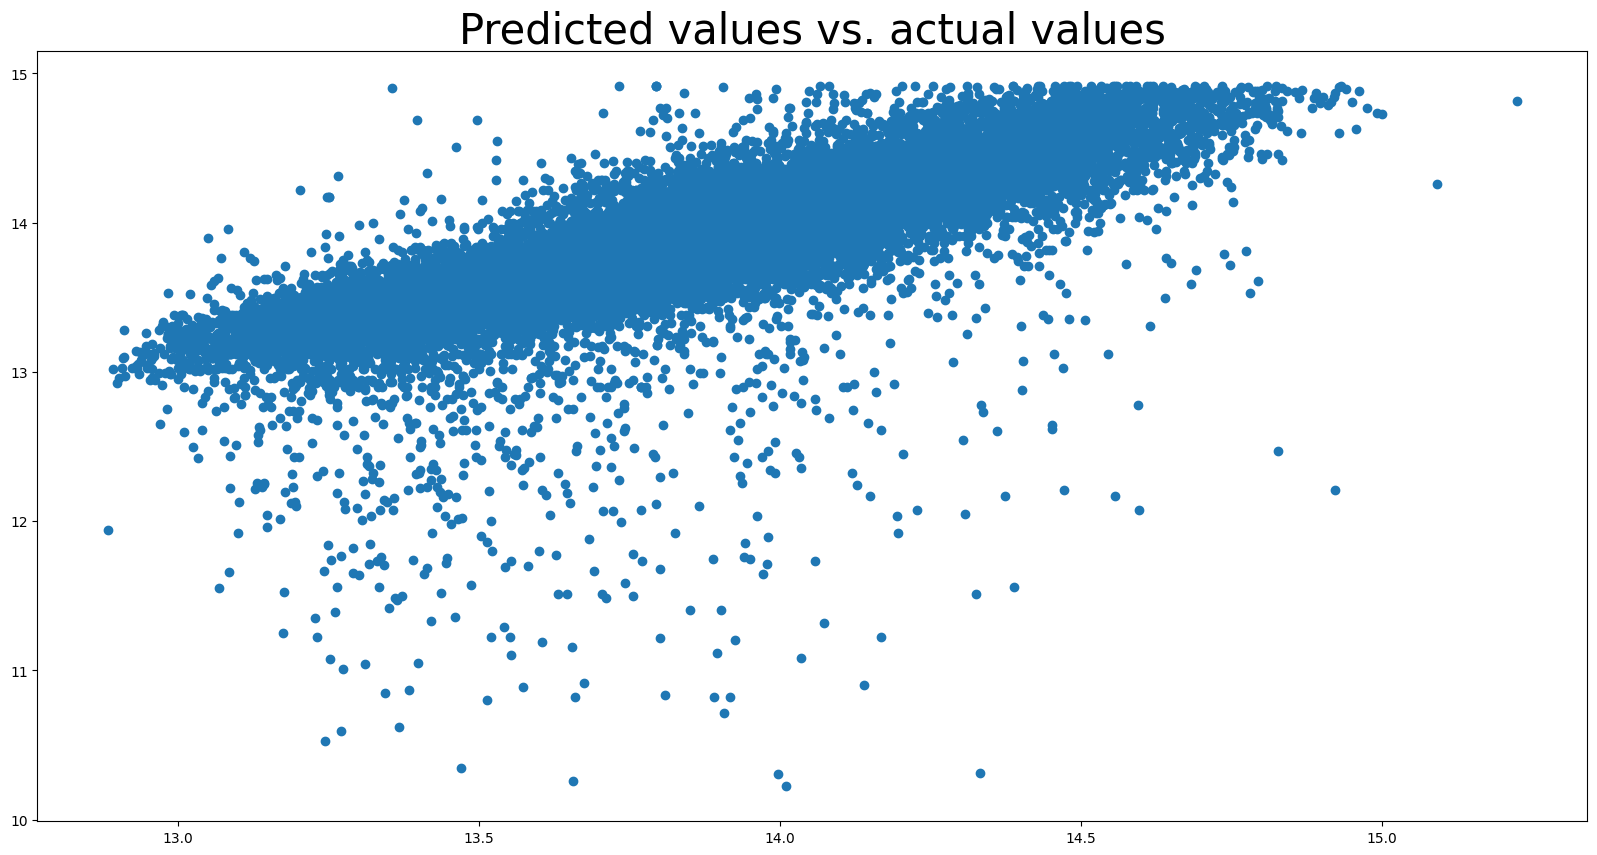

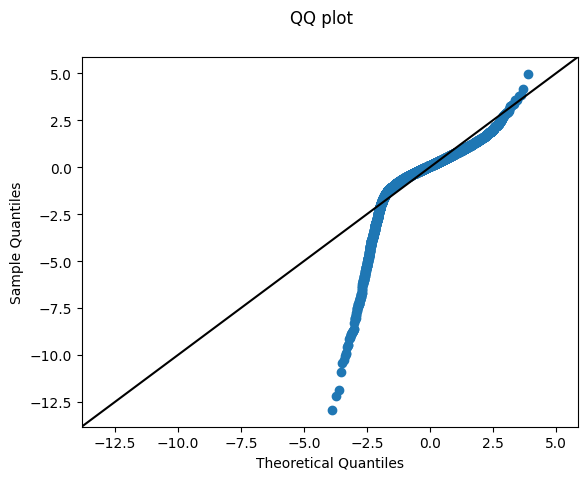

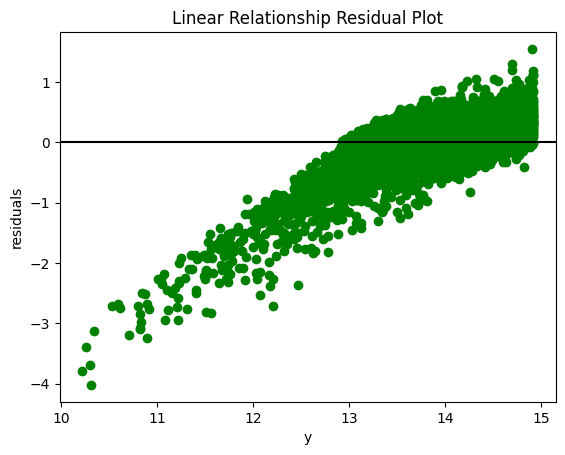

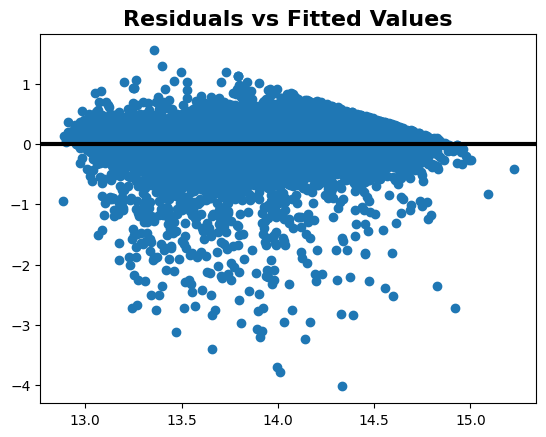

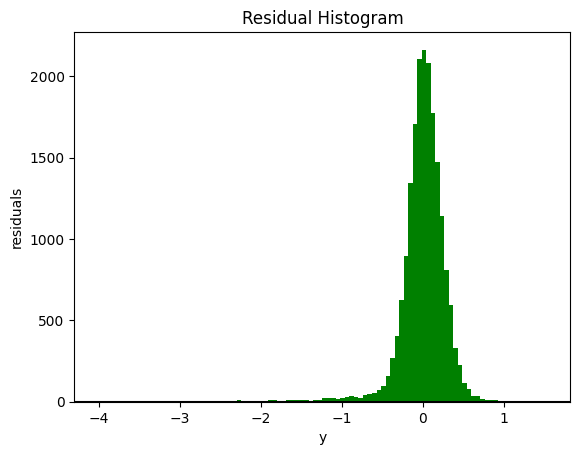

In [205]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(results.predict(houses), houses.price)
# ax.scatter(np.linspace(2.4,3.25,100), np.linspace(2.4,3.25,100), color="black")
ax.set_title("Predicted values vs. actual values", fontsize=30)
# ax.set_ylim(bottom=11, top=17)
# ax.set_xlim(left=12, right=16)

# fig = plt.figure(figsize=(15,10))
# sm.graphics.plot_partregress_grid(results, fig=fig)
# print("\n")

fig, ax = plt.subplots()
sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True, ax=ax)
line = ax.lines[1]
line.set_color("black")
fig.suptitle("QQ plot")

fig, ax = plt.subplots()
ax.scatter(model.endog, results.resid, color="green")
ax.axhline(y=0, color="black")
ax.set_xlabel("y")
ax.set_ylabel("residuals")
ax.set_title("Linear Relationship Residual Plot")

fitted_values = results.predict(houses)
residuals = houses.price - fitted_values
fig, ax = plt.subplots()
ax.scatter(fitted_values, residuals)
ax.axhline(y=0, color='black', linestyle='-', linewidth=3)
ax.set_title('Residuals vs Fitted Values', fontsize=16, weight='bold')

fig, ax = plt.subplots()
ax.hist(results.resid, color="green", bins=100)
ax.axhline(y=0, color="black")
ax.set_xlabel("y")
ax.set_ylabel("residuals")
ax.set_title("Residual Histogram")

mae = mean_absolute_error(houses.price, results.predict(houses))
rmse = mean_squared_error(houses.price, results.predict(houses))
print (f"MAE: {mae}\nRMSE: {rmse}")

Log-transforming the data did not make a substantial difference.